This notebook is meant to be run in Google Colab, please upload the data files before running



# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor

In [3]:
! mkdir imgs

mkdir: cannot create directory ‘imgs’: File exists


# Read the datasets

In [3]:
! unzip '/content/2024-adatelemzo-msc.zip'

Archive:  /content/2024-adatelemzo-msc.zip
replace 2024-adatelemzo-msc/ddos_data.attacks.anonimized.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 2024-adatelemzo-msc/ddos_data.vectors.anonimized.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# path to the files
attacks_path = '/content/2024-adatelemzo-msc/ddos_data.attacks.anonimized.csv'
vectors_path = '/content/2024-adatelemzo-msc/ddos_data.vectors.anonimized.csv'

In [5]:
attack_df = pd.read_csv(attacks_path)
attack_df.head()

,Attack ID,Card,Victim IP,Port number,Attack code,Detect count,Significant flag,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,End time,Whitelist flag,Type
0,1,sga10gq0,IP_0001,4500,High volume traffic,1,0,55600,73,1383,6,2022-08-08T18:09:36,2022-08-08T18:09:37,0,Normal traffic
1,2,sga10gq0,IP_0002,4500,High volume traffic,1,0,63500,90,1506,1,2022-08-08T18:37:28,2022-08-08T18:37:28,0,Normal traffic
2,3,sga10gq0,IP_0003,1200,High volume traffic,2,0,62700,82,1399,1,2022-08-08T18:41:25,2022-08-08T18:41:26,0,Normal traffic
3,4,sga10gq0,IP_0002,4500,High volume traffic,1,0,59500,85,1486,1,2022-08-08T18:47:49,2022-08-08T18:47:50,0,Normal traffic
4,5,sga10gq0,IP_0004,12347,High volume traffic,2,1,78250,113,1518,1,2022-08-08T18:57:15,2022-08-08T18:58:11,0,Normal traffic


In [133]:
vector_df = pd.read_csv(vectors_path)
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49


# Preprocess the data

In [134]:
# add labels to the vectors df
vector_df = pd.merge(vector_df, attack_df[['Attack ID', 'Type']], on='Attack ID', how='left')
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time,Type
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36,Normal traffic
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28,Normal traffic
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25,Normal traffic
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26,Normal traffic
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49,Normal traffic


In [135]:
# column types
vector_df.dtypes

Attack ID            int64
Detect count         int64
Card                object
Victim IP           object
Port number          int64
Attack code         object
Significant flag     int64
Packet speed         int64
Data speed           int64
Avg packet len       int64
Source IP count      int64
Time                object
Type                object
dtype: object

In [137]:
# Attack labels
# convert string to list
vector_df['attack code list'] = vector_df['Attack code'].apply(lambda x: x.replace(', ',',').split(','))
# encode the attack labels in a binary format
mlb = MultiLabelBinarizer()

# Transform labels into binary format
code_lists = mlb.fit_transform(vector_df["attack code list"])

vector_df["attack code list"] = [arr for arr in code_lists]
vector_df["attack code list"]

0         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
1         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
2         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
3         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
                                ...                        
586637    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
586638    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
586639    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
586640    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
586641    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: attack code list, Length: 586642, dtype: object

In [22]:
# drop columns
cols_to_drop = ['Card', 'Victim IP', 'Attack ID', 'Detect count', 'Attack code', 'Significant flag', 'Time']

full_vector_df = vector_df
vector_df = vector_df.drop(cols_to_drop, axis=1)

vector_df.dtypes

Port number          int64
Packet speed         int64
Data speed           int64
Avg packet len       int64
Source IP count      int64
Type                object
attack code list    object
dtype: object

# Augmemtation

We are using the SMOTE algorithm

In [141]:
# Define categorical and numerical columns
numerical_cols = ['Port number', 'Packet speed', 'Data speed', 'Avg packet len', 'Source IP count']
array_col = 'attack code list'
target_col = 'Type'

In [142]:
# Define preprocessing steps for numerical columns
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols)
])

In [143]:
# Flatten the array column
flattened_array = vector_df[array_col].apply(pd.Series).values

# Combine preprocessed columns with flattened array column
combined_features = pd.concat([
    pd.DataFrame(preprocessor.fit_transform(vector_df), columns=numerical_cols),
    pd.DataFrame(flattened_array, columns=[f'{array_col}_{i}' for i in range(len(flattened_array[0]))])
], axis=1)

combined_features

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,attack code list_0,attack code list_1,attack code list_2,attack code list_3,attack code list_4,...,attack code list_7,attack code list_8,attack code list_9,attack code list_10,attack code list_11,attack code list_12,attack code list_13,attack code list_14,attack code list_15,attack code list_16
0,-0.797923,-0.277770,-0.170063,0.718870,-0.119381,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.797923,-0.183982,0.032760,0.935490,-0.138697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.925953,-0.229095,-0.098479,0.747049,-0.138697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.925953,-0.157864,-0.014963,0.747049,-0.138697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.797923,-0.231469,-0.026894,0.900267,-0.138697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586637,-0.972509,-0.328819,-0.277441,0.616725,-0.138697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586638,-0.792840,-0.118686,-0.050755,0.512818,-0.138697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586639,-0.792840,-0.294391,-0.265510,0.516340,-0.138697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586640,1.056108,-0.110376,0.008899,0.604397,-0.115518,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
combined_features.dtypes

Port number            float64
Packet speed           float64
Data speed             float64
Avg packet len         float64
Source IP count        float64
attack code list_0       int64
attack code list_1       int64
attack code list_2       int64
attack code list_3       int64
attack code list_4       int64
attack code list_5       int64
attack code list_6       int64
attack code list_7       int64
attack code list_8       int64
attack code list_9       int64
attack code list_10      int64
attack code list_11      int64
attack code list_12      int64
attack code list_13      int64
attack code list_14      int64
attack code list_15      int64
attack code list_16      int64
dtype: object

In [145]:
# Apply SMOTE to the combined features and target
smote = SMOTE(sampling_strategy='not majority', k_neighbors=20, random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_features, vector_df[target_col])

# Merge augmented data with original

## Transform augmented data

In [185]:
# Reshape the synthetic samples back into the original shape of the array column
synthetic_df = pd.DataFrame(X_resampled, columns=combined_features.columns)
synthetic_df[target_col] = y_resampled

# Separate the array columns from the rest of the synthetic DataFrame
synthetic_array_cols = synthetic_df[[col for col in synthetic_df.columns if col.startswith(array_col)]]

# Drop the array columns from the synthetic DataFrame
synthetic_df.drop([col for col in synthetic_df.columns if col.startswith(array_col)], axis=1, inplace=True)

# Combine the array columns with the rest of the synthetic DataFrame
#synthetic_df = pd.concat([synthetic_df, synthetic_array_cols], axis=1)
synthetic_df['attack code'] = [arr for arr in synthetic_array_cols.values]

# Create a new StandardScaler instance and fit it on the original data
scaler = StandardScaler()
scaler.fit(vector_df[numerical_cols])

# Inverse transform the numerical columns
final_numerical_cols = scaler.inverse_transform(synthetic_df[numerical_cols])

# Replace the transformed numerical columns with the original values
synthetic_df[numerical_cols] = final_numerical_cols

synthetic_df

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,Type,attack code
0,4500.000000,55600.000000,73.000000,1383.000000,6.000000,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4500.000000,63500.000000,90.000000,1506.000000,1.000000,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1200.000000,59700.000000,79.000000,1399.000000,1.000000,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1200.000000,65700.000000,86.000000,1399.000000,1.000000,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4500.000000,59500.000000,85.000000,1486.000000,1.000000,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
1346824,49261.000000,63389.463518,88.776341,1481.223659,2.000000,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1346825,57044.243676,72145.042160,84.591596,1270.900843,10.774789,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1346826,54404.300973,78384.466073,93.213592,1259.359223,13.427185,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1346827,51413.000000,80134.821745,5.000000,66.000000,2.116072,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [186]:
# convert columns
# round numericals
for col in numerical_cols:
  synthetic_df[col] = synthetic_df[col].apply(lambda x: int(np.round(x)))
synthetic_df

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,Type,attack code
0,4500,55600,73,1383,6,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4500,63500,90,1506,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1200,59700,79,1399,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1200,65700,86,1399,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4500,59500,85,1486,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
1346824,49261,63389,89,1481,2,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1346825,57044,72145,85,1271,11,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1346826,54404,78384,93,1259,13,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1346827,51413,80135,5,66,2,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [187]:
# reconstruct attack code
attack_codes = sorted(['Suspicious traffic', 'DNS', 'NTP', 'Sentinel', 'CHARGEN', 'SSDP', 'IPv4 fragmentation',
 'TCP Anomaly', 'SYN Attack', 'CLDAP', 'High volume traffic', 'RPC', 'RDP', 'SNMP', 'ACK Attack', 'CoAP', 'Generic UDP'])

synthetic_df['Attack code'] = synthetic_df['attack code'].apply(lambda x: [attack_codes[j] for j in [i for i, value in enumerate(x) if value == 1]])

synthetic_df

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,Type,attack code,Attack code
0,4500,55600,73,1383,6,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic]
1,4500,63500,90,1506,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic]
2,1200,59700,79,1399,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic]
3,1200,65700,86,1399,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic]
4,4500,59500,85,1486,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic]
...,...,...,...,...,...,...,...,...
1346824,49261,63389,89,1481,2,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic]
1346825,57044,72145,85,1271,11,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suspicious traffic]
1346826,54404,78384,93,1259,13,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suspicious traffic]
1346827,51413,80135,5,66,2,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suspicious traffic]


In [188]:
# add significant flag
synthetic_df['Significant flag'] = np.random.randint(2, size=len(synthetic_df))
synthetic_df

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,Type,attack code,Attack code,Significant flag
0,4500,55600,73,1383,6,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic],0
1,4500,63500,90,1506,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic],0
2,1200,59700,79,1399,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic],0
3,1200,65700,86,1399,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic],1
4,4500,59500,85,1486,1,Normal traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic],1
...,...,...,...,...,...,...,...,...,...
1346824,49261,63389,89,1481,2,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[High volume traffic],1
1346825,57044,72145,85,1271,11,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suspicious traffic],1
1346826,54404,78384,93,1259,13,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suspicious traffic],1
1346827,51413,80135,5,66,2,Suspicious traffic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suspicious traffic],1


In [189]:
final_synthetic_df = synthetic_df.drop(['attack code'], axis = 1)
final_synthetic_df

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,Type,Attack code,Significant flag
0,4500,55600,73,1383,6,Normal traffic,[High volume traffic],0
1,4500,63500,90,1506,1,Normal traffic,[High volume traffic],0
2,1200,59700,79,1399,1,Normal traffic,[High volume traffic],0
3,1200,65700,86,1399,1,Normal traffic,[High volume traffic],1
4,4500,59500,85,1486,1,Normal traffic,[High volume traffic],1
...,...,...,...,...,...,...,...,...
1346824,49261,63389,89,1481,2,Suspicious traffic,[High volume traffic],1
1346825,57044,72145,85,1271,11,Suspicious traffic,[Suspicious traffic],1
1346826,54404,78384,93,1259,13,Suspicious traffic,[Suspicious traffic],1
1346827,51413,80135,5,66,2,Suspicious traffic,[Suspicious traffic],1


In [190]:
# save the augmented data
final_synthetic_df.to_csv('imgs/synthetic_vectors.csv', index = False)

## Transform original data

In [191]:
final_synthetic_df.dtypes

Port number          int64
Packet speed         int64
Data speed           int64
Avg packet len       int64
Source IP count      int64
Type                object
Attack code         object
Significant flag     int64
dtype: object

In [193]:
# drop unused columns
original_df = full_vector_df.drop(['Card', 'Victim IP', 'Time', 'attack code list', 'ac_str'], axis=1)
original_df.dtypes

Attack ID            int64
Detect count         int64
Port number          int64
Attack code         object
Significant flag     int64
Packet speed         int64
Data speed           int64
Avg packet len       int64
Source IP count      int64
Type                object
dtype: object

In [199]:
# convert the attack codes to list
original_df['Attack code'] = original_df['Attack code'].apply(lambda x: x.replace(', ',',').split(','))

In [195]:
# add missing values
final_synthetic_df['synthetic'] = True
original_df['synthetic'] = False

final_synthetic_df['Attack ID'] = -1
final_synthetic_df['Detect count'] = -1

final_synthetic_df

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,Type,Attack code,Significant flag,synthetic,Attack ID,Detect count
0,4500,55600,73,1383,6,Normal traffic,[High volume traffic],0,True,-1,-1
1,4500,63500,90,1506,1,Normal traffic,[High volume traffic],0,True,-1,-1
2,1200,59700,79,1399,1,Normal traffic,[High volume traffic],0,True,-1,-1
3,1200,65700,86,1399,1,Normal traffic,[High volume traffic],1,True,-1,-1
4,4500,59500,85,1486,1,Normal traffic,[High volume traffic],1,True,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
1346824,49261,63389,89,1481,2,Suspicious traffic,[High volume traffic],1,True,-1,-1
1346825,57044,72145,85,1271,11,Suspicious traffic,[Suspicious traffic],1,True,-1,-1
1346826,54404,78384,93,1259,13,Suspicious traffic,[Suspicious traffic],1,True,-1,-1
1346827,51413,80135,5,66,2,Suspicious traffic,[Suspicious traffic],1,True,-1,-1


In [200]:
# merge the two dataframes
final_df = pd.concat([original_df, final_synthetic_df], ignore_index=True)

final_df

,Attack ID,Detect count,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Type,synthetic
0,1,1,4500,[High volume traffic],0,55600,73,1383,6,Normal traffic,False
1,2,1,4500,[High volume traffic],0,63500,90,1506,1,Normal traffic,False
2,3,1,1200,[High volume traffic],0,59700,79,1399,1,Normal traffic,False
3,3,2,1200,[High volume traffic],0,65700,86,1399,1,Normal traffic,False
4,4,1,4500,[High volume traffic],0,59500,85,1486,1,Normal traffic,False
...,...,...,...,...,...,...,...,...,...,...,...
1933466,-1,-1,49261,[High volume traffic],1,63389,89,1481,2,Suspicious traffic,True
1933467,-1,-1,57044,[Suspicious traffic],1,72145,85,1271,11,Suspicious traffic,True
1933468,-1,-1,54404,[Suspicious traffic],1,78384,93,1259,13,Suspicious traffic,True
1933469,-1,-1,51413,[Suspicious traffic],1,80135,5,66,2,Suspicious traffic,True


In [201]:
# save the data
final_synthetic_df.to_csv('imgs/all_vectors.csv', index = False)

In [219]:
! zip -r images.zip imgs

  adding: imgs/ (stored 0%)
  adding: imgs/.ipynb_checkpoints/ (stored 0%)
  adding: imgs/synth_vector_df_violin_Data speed.jpg (deflated 36%)
  adding: imgs/synth_vector_df_violin_Packet speed.jpg (deflated 38%)
  adding: imgs/synth_vector_df_violin_Avg packet len.jpg (deflated 31%)
  adding: imgs/vector_df_violin_Packet speed.jpg (deflated 38%)
  adding: imgs/vector_df_violin_Data speed.jpg (deflated 35%)
  adding: imgs/vector_df_violin_Avg packet len.jpg (deflated 31%)
  adding: imgs/vector_df_violin_Source IP count.jpg (deflated 38%)
  adding: imgs/synth_vector_df_violin_Source IP count.jpg (deflated 39%)
  adding: imgs/vector_df_type_dist.jpg (deflated 26%)


# Analyse new dataset

In [203]:
vector_df = final_df

Type
Normal traffic        897886
DDoS attack           528007
Suspicious traffic    507578
Name: count, dtype: int64


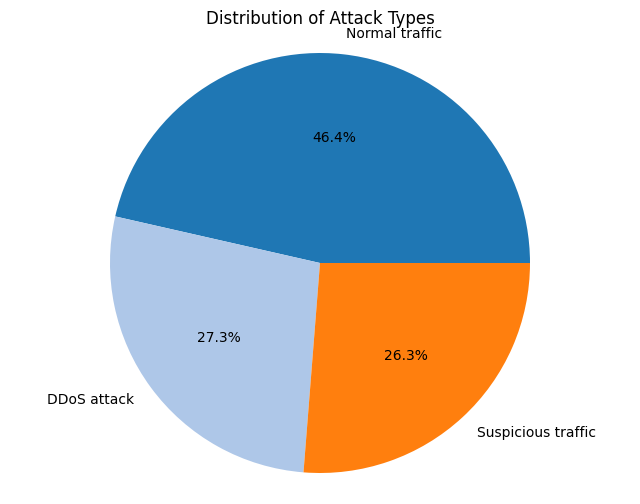

In [204]:
# see how many records are in different classes
value_counts = vector_df['Type'].value_counts()
labels = sorted(value_counts.index)
print(value_counts)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(value_counts.values, labels = value_counts.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors)
plt.axis('equal')
plt.title("Distribution of Attack Types")

plt.savefig('imgs/vector_df_type_dist.jpg', bbox_inches='tight')

plt.show()


Type
Normal traffic        448943
Suspicious traffic    448943
DDoS attack           448943
Name: count, dtype: int64


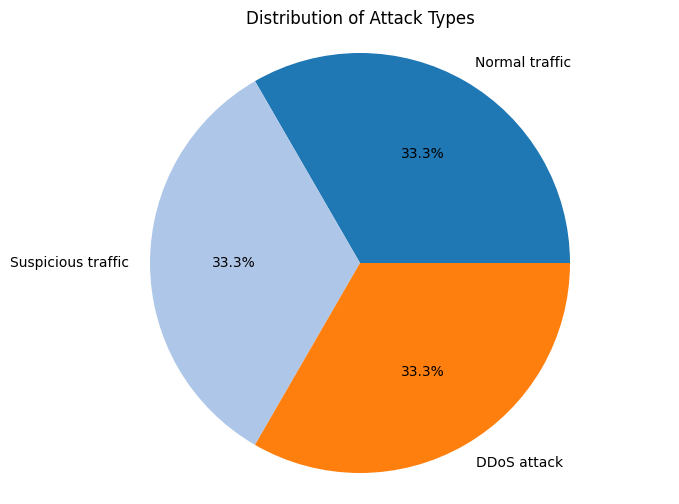

In [205]:
# see how many records are in different classes in the synthetic data
value_counts = vector_df[vector_df['synthetic'] == True]['Type'].value_counts()
labels = sorted(value_counts.index)
print(value_counts)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(value_counts.values, labels = value_counts.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors)
plt.axis('equal')
plt.title("Distribution of Attack Types")

plt.savefig('imgs/vector_df_type_dist.jpg', bbox_inches='tight')

plt.show()

In [212]:
def create_violin_plots(df, col, z_scores, threshold, synth = False):
  # Plot the violin plot without the outliers
  plt.figure(figsize=(8, 6))

  # create a seperate plot for each class
  data = []
  for label in labels:
    data.append(df[(df['Type'] == label) & (z_scores <= threshold) & (z_scores >= -threshold)][col])
  # also for the whole dataset
  data.append(df[(z_scores <= threshold) & (z_scores >= -threshold)][col])

  # plot
  parts = plt.violinplot(data, showmeans = True, showextrema=True, showmedians=True)

  # Set the colors for the violins based on the category
  colors = ['Blue', 'Green', 'Purple', 'salmon']

  # Set the color of the violin patches
  for pc, color in zip(parts['bodies'], colors):
      pc.set_facecolor(color)

  # Create legend labels and handles for each violin plot
  legend_labels = list(labels)
  legend_labels.append('All data')
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]

  # Plot settings
  plt.legend(legend_handles, legend_labels)
  plt.title(f'Violin plot of {col} by label')
  plt.ylabel('Values')
  plt.xlabel('Density')
  plt.grid(True)

  # decide what df is used
  if '' in df:
    df_type = 'attack'
  else:
    df_type = 'vector'

  if synth:
    plt.savefig(f"imgs/synth_{df_type}_df_violin_{col}.jpg", bbox_inches='tight')
  else:
    plt.savefig(f"imgs/{df_type}_df_violin_{col}.jpg", bbox_inches='tight')

  plt.show()

In [209]:
def calculate_zscores(df, col):
  mean = df[col].mean()
  std_dev = df[col].std()

  # Calculate Z-scores
  z_scores = (df[col] - mean) / std_dev

  return z_scores


<ipython-input-212-b06d6d0ea61c>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


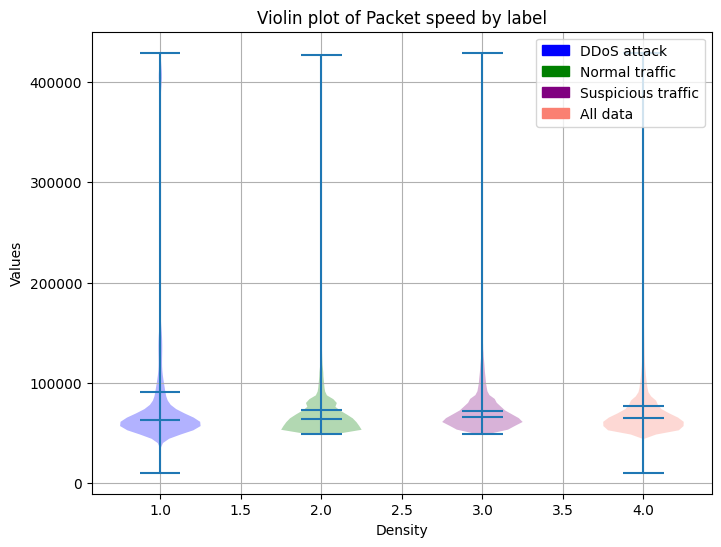

<ipython-input-212-b06d6d0ea61c>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


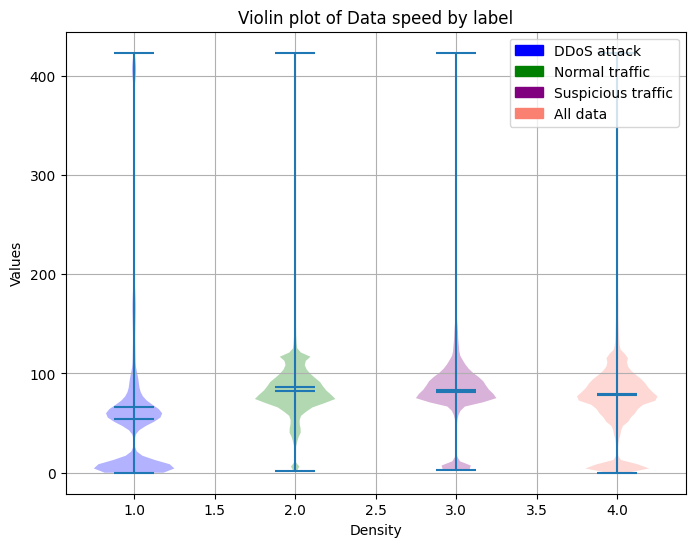

<ipython-input-212-b06d6d0ea61c>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


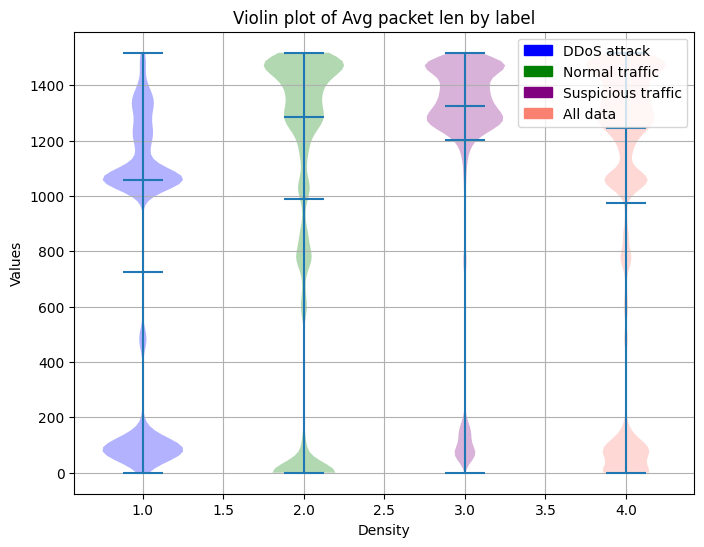

<ipython-input-212-b06d6d0ea61c>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


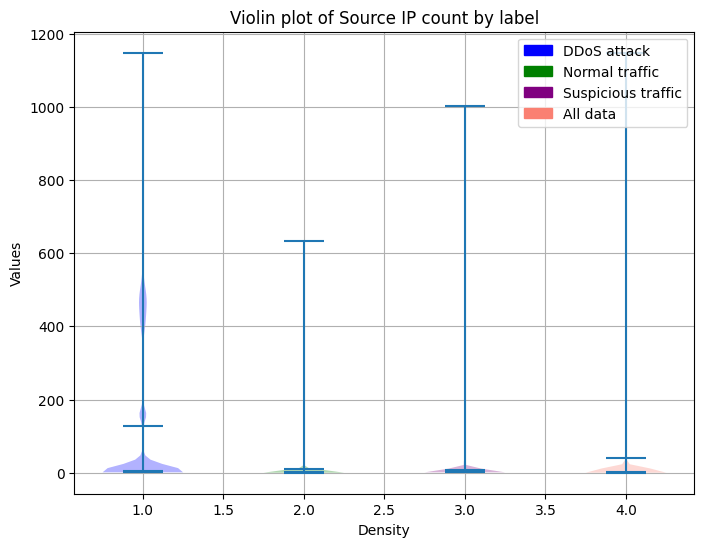

In [215]:
columns_to_plot = ['Packet speed', 'Data speed', 'Avg packet len', 'Source IP count']

for col in columns_to_plot:
  zscores = calculate_zscores(vector_df, col)
  create_violin_plots(vector_df, col, zscores, threshold = 3)

<ipython-input-212-b06d6d0ea61c>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


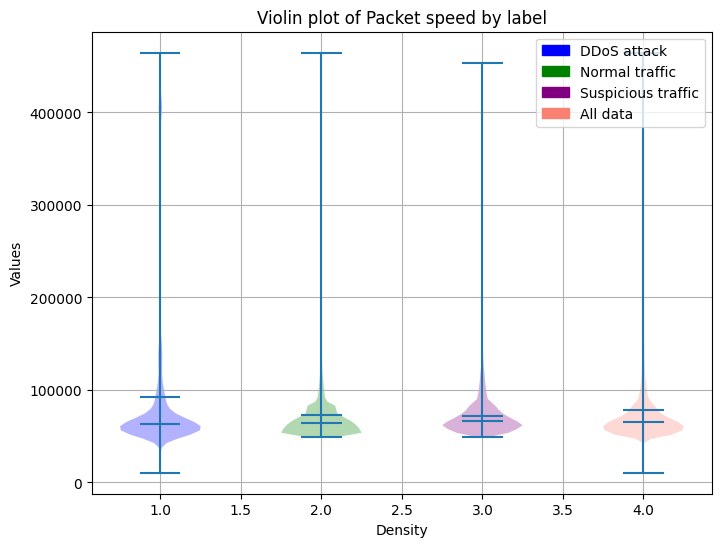

<ipython-input-212-b06d6d0ea61c>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


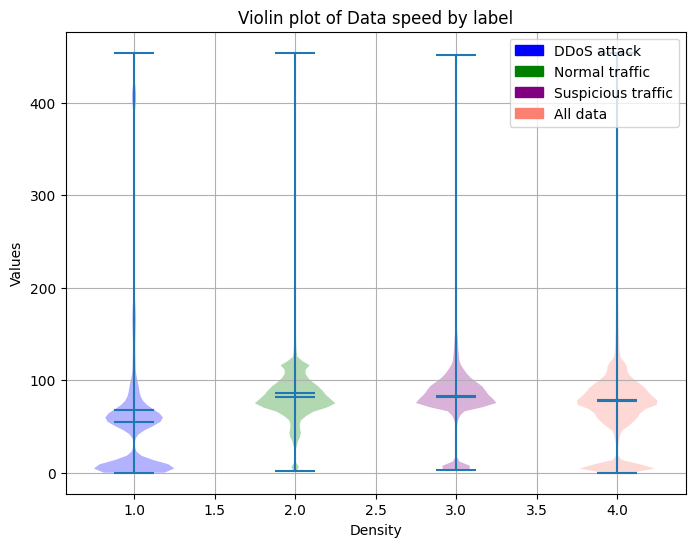

<ipython-input-212-b06d6d0ea61c>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


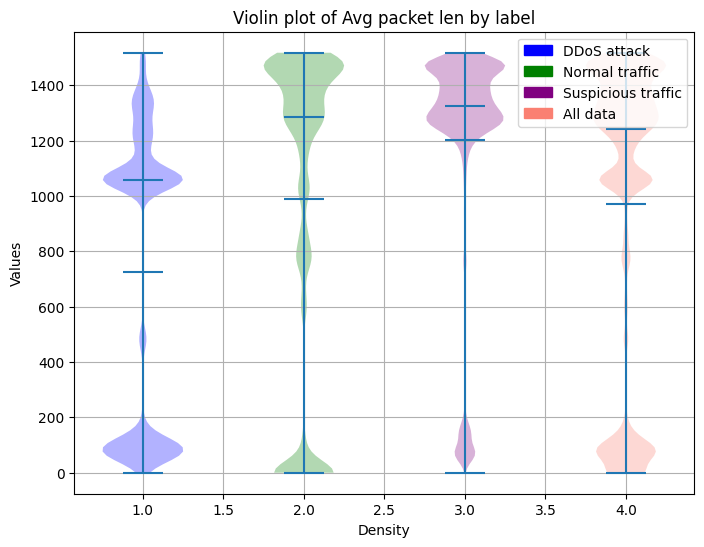

<ipython-input-212-b06d6d0ea61c>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


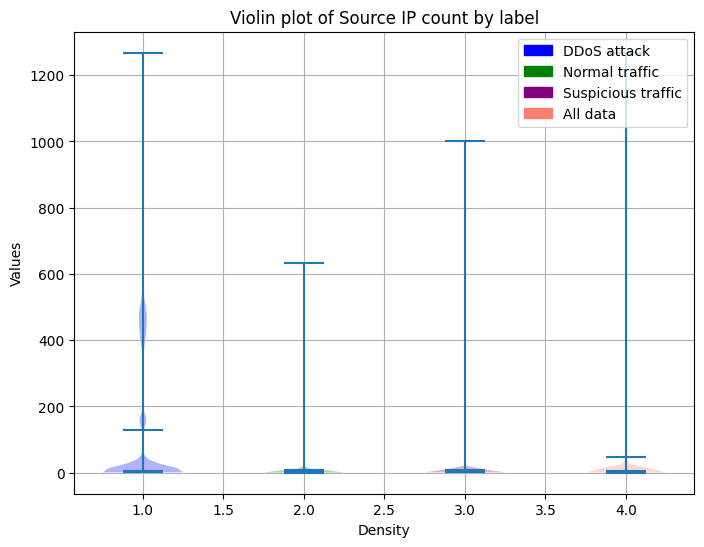

In [216]:
columns_to_plot = ['Packet speed', 'Data speed', 'Avg packet len', 'Source IP count']

for col in columns_to_plot:
  zscores = calculate_zscores(vector_df[vector_df['synthetic'] == True], col)
  create_violin_plots(vector_df[vector_df['synthetic'] == True], col, zscores, threshold = 3, synth = True)